In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

import sys
import seaborn as sns
from multiprocessing import Queue, Event, Process

sys.path.insert(0, '/home/chwala-c/code/pySNMPdaq/')
from pySNMPdaq import SnmpDAQSession

Populating the interactive namespace from numpy and matplotlib


/home/chwala-c/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7959       2890       5068          0        331       1127
-/+ buffers/cache:       1432       6527
Swap:         1624          0       1624


In [7]:
N = 10

snmpDAQSessions = []

query_results_queue = Queue()

for i in range(N):
    session = SnmpDAQSession(IP='123.321.123.321',
                            ID='foobar' + str(i),
                            oid_dict={'foo':'1.3.6.1.2.1.1.3'},
                            WRITE_TO_FILE=False,
                            WRITE_TO_STDOUT=False,
                            timeout=1*1000000, # microseconds
                            retries=2,
                            query_results_queue=query_results_queue)
    session.start_listener()
    snmpDAQSessions.append(session)

In [8]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7959       2952       5006          0        332       1128
-/+ buffers/cache:       1492       6467
Swap:         1624          0       1624


In [9]:
for session in snmpDAQSessions:
    session.stop_listener()
    #print 'Terminating SNMP query processe...'
    session.listener_process.terminate()
    #print 'Joining SNMP query processe...'
    session.listener_process.join()

In [10]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7959       2920       5039          0        332       1128
-/+ buffers/cache:       1458       6500
Swap:         1624          0       1624


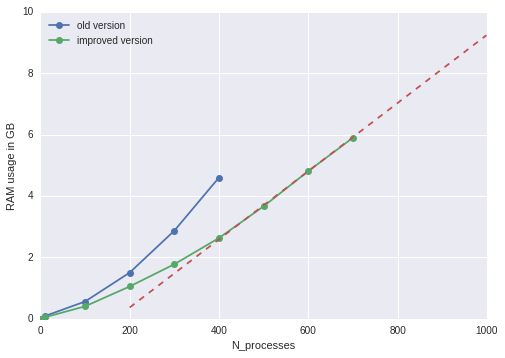

In [2]:
N = [0, 10, 100, 200, 300, 400, 500, 600, 700]
old_mem = array([2607, 2697, 3170, 4114, 5479, 7211, nan, nan, nan])/1e3
new_mem = array([2362, 2455, 2869, 3567, 4579, 5920, nan, nan, nan])/1e3
nv2_mem = array([1929, 1978, 2336, 2983, 3708, 4562, 5596, 6742, 7827])/1e3

plot(N, array(old_mem)-old_mem[0], '-o', label='old version')
#plot(N, array(new_mem)-new_mem[0], '-o')
plot(N, array(nv2_mem)-nv2_mem[0], '-o', label='improved version')
plot(arange(200,1000), (arange(200,1000)*11.1-1850)/1e3, '--')

legend(loc=2)
xlabel('N_processes')
ylabel('RAM usage in GB')
savefig('/home/chwala-c/Dropbox//misc/pySNMPdaq_RAM_usage_improved.png', dpi=300)

# Plot memory consumptions for different interprocess communications 

Data is produced by `test_run_fixed_N.py` which is called by `call_test_run_fixed_N.sh`. The bash-script is used to avioid accumulating memory consumption which happens in a python script that iterates over different `N`s and initializes and kill the corresponding processes. Python seem not to clean up completely as long as the inital "partent" process, here the script, runs.

 * Implementation #0 uses the current snmpDAQSession implementation which uses an `Event()` per Session to trigger the request
 * Implementation #1 uses a dummy class and a `Queue()` for triggering each `Process()`.
 * Implementation #2 uses a dummy class and an `Event()` for triggering each `Process()`.
 * Implementation #3 uses a dummy class and has no interprocess communication, no `Queue()`, no `Event()`.
 * Implementation #4 similar to #3 but the worker is no a Class method
 * Implementation #5 uses a dummy class and only one `Queue()` for triggering all `Process()`es.
   * Question: How fast is putting and getting 1000 objects to one `Queue()` compared to setting 1000 `Events()`? See test below

In [2]:
import pandas as pd

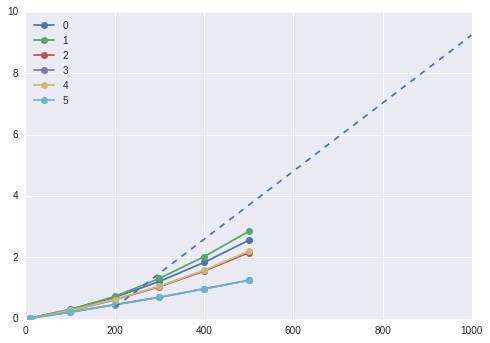

In [3]:
df = pd.read_csv('/home/chwala-c/code/pySNMPdaq/mem_test_results.csv',
                 names=['implementation', 'N', 'mem_before', 'mem_during', 'mem_after'])

grouped = df.groupby(['implementation'])

for name, group in grouped:
    plot(group.N, group.mem_during-group.mem_before, '-o', label=name)
    legend(loc=2)
plot(arange(200,1000), (arange(200,1000)*11.1-1850)/1e3, '--')


# Test performance of putting and getting 1000 objects to a `Queue()`

In [2]:
import os
from time import sleep
from datetime import datetime


N = 10

input_queue = Queue()
output_queue = Queue()

class SnmpSessionDummy():
    def __init__(self,i):
        self.foo = 'bar'
        self.id = i
    def query(self):
        print 'do snmp query that typically takes at least 0.1 seconds'
        sleep(0.1)
        output_queue.put((self.id, datetime.utcnow()))

def worker(input_queue):
    while True:
        snmp_session = input_queue.get()
        print 'PID %s got somthing from the queue' % os.getpid()
        snmp_session.query()
        
snmp_sessions = []
jobs = []
        
print 'Init session and processes'    

for i in range(N):
    snmp_sessions.append(SnmpSessionDummy(i))
    p = Process(target=worker, args=(input_queue,))
    p.start()
    jobs.append(p)
    
print 'put sessions to queue'
    
for snmp_session in snmp_sessions:
    input_queue.put(snmp_session)
    
sleep(1)
  
for snmp_session in snmp_sessions:
    input_queue.put(snmp_session)
    
sleep(5)
    
print 'terminate processes'
    
for p in jobs:
    p.join()
    p.terminate()


Init session and processes
put sessions to queue
terminate processesPID 17707 got somthing from the queue
PID 17708 got somthing from the queue
PID 17709 got somthing from the queue
PID 17710 got somthing from the queue
PID 17712 got somthing from the queue
PID 17714 got somthing from the queue
PID 17715 got somthing from the queue
PID 17716 got somthing from the queue
PID 17718 got somthing from the queue
PID 17717 got somthing from the queue
do snmp query that typically takes at least 0.1 seconds
do snmp query that typically takes at least 0.1 seconds
do snmp query that typically takes at least 0.1 seconds
do snmp query that typically takes at least 0.1 seconds
do snmp query that typically takes at least 0.1 seconds
do snmp query that typically takes at least 0.1 seconds
do snmp query that typically takes at least 0.1 seconds
do snmp query that typically takes at least 0.1 seconds
do snmp query that typically takes at least 0.1 seconds
do snmp query that typically takes at least 0.1 

Process Process-4:
Process Process-2:
Process Process-9:
Process Process-8:
Process Process-7:
Process Process-1:
Process Process-6:
Process Process-5:
Process Process-3:
Process Process-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/chwala-c/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/chwala-c/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/chwala-c/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/chwala-c/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/chwala-c/anaconda/lib/python2.7/multiprocessing/p

KeyboardInterrupt: 

In [ ]:
while not output_queue.empty():
    print output_queue.get()